In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2025-09-08 09:29:53.278476: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 09:29:53.280063: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 09:29:53.305490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 09:29:53.306093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-08 09:29:53.740755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [3]:
import tensorflow as tf
print("Devices:", tf.config.list_physical_devices())


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-09-08 09:30:25.525591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-08 09:30:25.526198: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler

my_file = "./Nmetil.MDE"

df = pd.read_csv(
    my_file,
    sep=r"\s+",
    comment='#',
    names=["Step", "T", "E_KS", "E_tot", "Vol", "P"]
)

print(f"Dimensiunea inițială: {len(df)} rânduri")
print(f"Numărul de step-uri unice: {df['Step'].nunique()}")

# Pentru a păstra toate datele din fiecare step, setează rows_per_group foarte mare
# sau folosește len(df) pentru a fi sigur că iei totul
rows_per_group = len(df)  # sau poți pune 10000 dacă vrei o valoare fixă

# Adauga pozitia in grup in df
df['pos_in_group'] = df.groupby('Step').cumcount()

# Varianta cumcount + mask
start_cumcount = time.time()
mask = df.groupby("Step").cumcount().between(1, rows_per_group)
df_data = df[mask].copy()
df_data['pos_in_group'] = df.loc[mask, 'pos_in_group']
time_cumcount = time.time() - start_cumcount

# Sortare dupa Step si pos_in_group
df_data = df_data.sort_values(['Step', 'pos_in_group']).reset_index(drop=True)

print(f"Dimensiunea după filtrare: {len(df_data)} randuri")
print(f"Range E_tot: [{df_data['E_tot'].min():.6f}, {df_data['E_tot'].max():.6f}] eV")

# Scaleaza energia
scaler = MinMaxScaler()
df_data['Energy_scaled'] = scaler.fit_transform(df_data[['E_tot']])

# Valori originale
print("\nPrimele 10 valori originale E_tot si scalate Energy_scaled:")
print(df_data[['E_tot', 'Energy_scaled']].head(10))

print(f"Timp varianta cumcount: {time_cumcount:.4f} secunde")

Dimensiunea inițială: 93300 rânduri
Numărul de step-uri unice: 100
Dimensiunea după filtrare: 93200 randuri
Range E_tot: [-1300.586730, -1300.032630] eV

Primele 10 valori originale E_tot si scalate Energy_scaled:
        E_tot  Energy_scaled
0 -1300.42458       0.292637
1 -1300.43292       0.277585
2 -1300.44254       0.260224
3 -1300.45337       0.240679
4 -1300.46502       0.219653
5 -1300.47709       0.197870
6 -1300.48883       0.176683
7 -1300.50018       0.156199
8 -1300.51052       0.137538
9 -1300.51943       0.121458
Timp varianta cumcount: 0.0077 secunde


In [5]:
# ## 2. Preprocesare Simplificată

# %%
# Selectare doar coloanele necesare
features = ['T', 'E_tot', 'Vol', 'P']  # Features pentru predicție
target = 'E_KS'                        # Target

# Extrage datele
X_data = df_data[features].values
y_data = df_data[target].values

print(f"Shape features: {X_data.shape}")
print(f"Shape target: {y_data.shape}")

# Scalare
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_data)
y_scaled = scaler_y.fit_transform(y_data.reshape(-1, 1)).flatten()

print("Scalare completă")

Shape features: (93200, 4)
Shape target: (93200,)
Scalare completă


In [6]:
def create_sequences_multi_step(X, y, sequence_length, out_steps):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length - out_steps + 1):
        sequences_X.append(X[i:i + sequence_length])
        sequences_y.append(y[i + sequence_length:i + sequence_length + out_steps])
    return np.array(sequences_X), np.array(sequences_y)

# Parametri
SEQUENCE_LENGTH = 200
OUT_STEPS = 20

X_seq, y_seq = create_sequences_multi_step(X_scaled, y_scaled, SEQUENCE_LENGTH, OUT_STEPS)

print(f"X shape: {X_seq.shape}")  # (num_samples, 200, num_features)
print(f"y shape: {y_seq.shape}")  # (num_samples, 20)


X shape: (92981, 200, 4)
y shape: (92981, 20)


In [7]:
total_samples = len(X_seq)
train_size = int(total_samples * 0.7)   # 70% pentru antrenare
val_size = int(total_samples * 0.15)    # 15% pentru validare
test_size = total_samples - train_size - val_size  # restul pentru test

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

print(f"Dimensiuni train: {X_train.shape}, {y_train.shape}")
print(f"Dimensiuni val: {X_val.shape}, {y_val.shape}")
print(f"Dimensiuni test: {X_test.shape}, {y_test.shape}")


Dimensiuni train: (65086, 200, 4), (65086, 20)
Dimensiuni val: (13947, 200, 4), (13947, 20)
Dimensiuni test: (13948, 200, 4), (13948, 20)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def build_optimized_lstm_model(input_shape, out_steps=20):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2),
        BatchNormalization(),
        LSTM(64, return_sequences=False, dropout=0.2),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dense(out_steps)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

# Construiește modelul
model = build_optimized_lstm_model(input_shape=(200, 4), out_steps=20)
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 128)          68096     
                                                                 
 batch_normalization (BatchN  (None, 200, 128)         512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 20)                1

2025-09-08 09:30:51.177448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 09:30:51.178212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 09:30:51.178684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



# Salvează modelul final (opțional, pe lângă ModelCheckpoint)
model.save('nmetil_model_9.keras')

# Evaluare
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


Epoch 1/20


2025-09-08 09:30:55.905419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 09:30:55.906254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 09:30:55.906760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1017/1017 [==============================] - ETA: 0s - loss: 0.0879 - mae: 0.2178

2025-09-08 09:32:41.552820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 09:32:41.553413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 09:32:41.553975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1017/1017 [==============================] - 112s 108ms/step - loss: 0.0879 - mae: 0.2178 - val_loss: 0.0296 - val_mae: 0.1329 - lr: 0.0010
Epoch 2/20
1017/1017 [==============================] - 112s 110ms/step - loss: 0.0417 - mae: 0.1594 - val_loss: 0.0270 - val_mae: 0.1243 - lr: 0.0010
Epoch 3/20
1017/1017 [==============================] - 111s 109ms/step - loss: 0.0350 - mae: 0.1457 - val_loss: 0.0244 - val_mae: 0.1185 - lr: 0.0010
Epoch 4/20
1017/1017 [==============================] - 111s 109ms/step - loss: 0.0312 - mae: 0.1376 - val_loss: 0.0241 - val_mae: 0.1188 - lr: 0.0010
Epoch 5/20
1017/1017 [==============================] - 115s 114ms/step - loss: 0.0286 - mae: 0.1313 - val_loss: 0.0229 - val_mae: 0.1147 - lr: 0.0010
Epoch 6/20
1017/1017 [==============================] - 103s 102ms/step - loss: 0.0268 - mae: 0.1269 - val_loss: 0.0202 - val_mae: 0.1078 - lr: 0.0010
Epoch 7/20
1017/1017 [==============================] - 99s 97ms/step - loss: 0.0243 - mae: 0.1208 - val_

2025-09-08 10:06:21.794651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 10:06:21.795389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 10:06:21.795859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

🏆 Performanța modelului:
   ├── MSE: 0.00019566 eV²
   ├── MAE: 0.01068472 eV
   ├── RMSE: 0.01398771 eV
   ├── MAPE: 0.00%
   └── R²: 0.983188 (98.32%)

📏 Context E_KS:
   ├── Range: [-1300.723390, -1300.230460] eV
   └── Amplitudine: 0.492930 eV


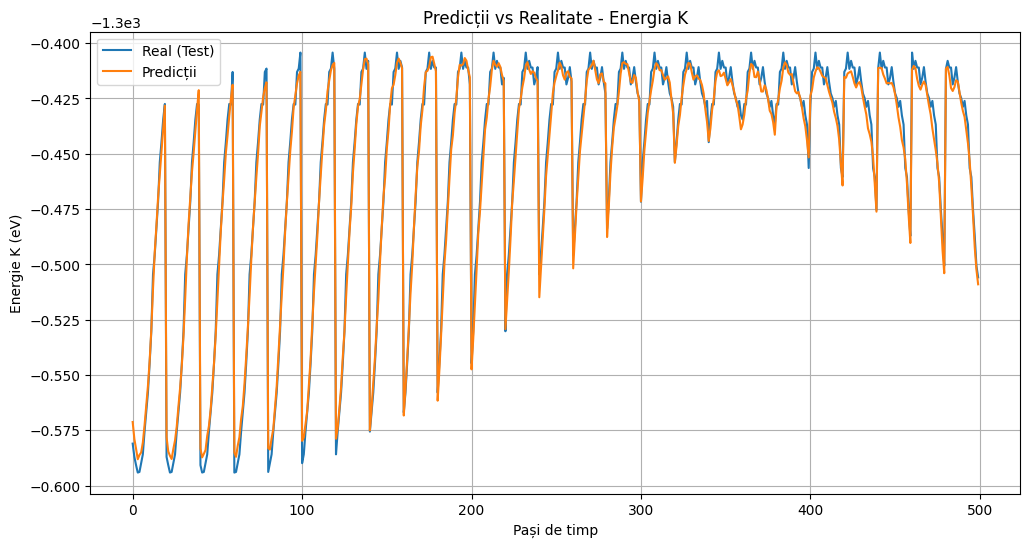

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictii pe setul de test
y_pred = model.predict(X_test, verbose=0)

# Inversare scalare pentru a reveni la valorile originale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calcul metrici
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# MAPE (doar dacă valorile reale nu includ zero)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"🏆 Performanța modelului:")
print(f"   ├── MSE: {mse:.8f} eV²")
print(f"   ├── MAE: {mae:.8f} eV")
print(f"   ├── RMSE: {rmse:.8f} eV")
print(f"   ├── MAPE: {mape:.2f}%")
print(f"   └── R²: {r2:.6f} ({r2*100:.2f}%)")

print(f"\n📏 Context E_KS:")
print(f"   ├── Range: [{y_test_original.min():.6f}, {y_test_original.max():.6f}] eV")
print(f"   └── Amplitudine: {y_test_original.max() - y_test_original.min():.6f} eV")

# Plot comparativ predicții vs realitate
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:500], label='Real (Test)')
plt.plot(y_pred_original[:500], label='Predicții')
plt.title('Predicții vs Realitate - Energia K')
plt.xlabel('Pași de timp')
plt.ylabel('Energie K (eV)')
plt.legend()
plt.grid(True)
plt.show()

# Salvare model final
# model.save('final_lstm_model.keras')
# print("Modelul a fost salvat ca 'final_lstm_model.keras'")


421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
(13468, 20) (13468, 200, 4) (13468, 20)
(269360, 1) (269360, 1)


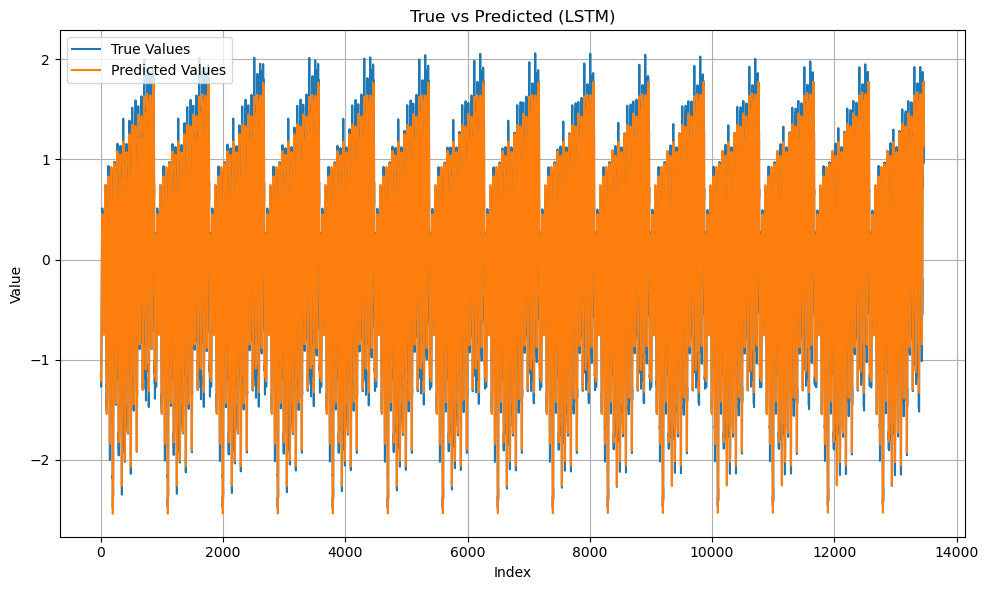

In [14]:
import matplotlib.pyplot as plt

# Predicții
predictions = model.predict(X_test)
print(predictions.shape, X_test.shape, y_test.shape)

# Inversare scaling (dacă folosești scaler pe ieșire)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))
print(predictions_inverted.shape, y_test_inverted.shape)

# Grafic True vs Predicted pentru prima valoare din fiecare fereastră
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='True Values')
plt.plot(predictions[:, 0], label='Predicted Values')
plt.title('True vs Predicted (LSTM)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🏆 Performanța modelului (date normalizate):
   ├── MSE: 0.00942866
   ├── MAE: 0.07072285
   ├── RMSE: 0.09710131
   ├── MAPE: 49.15%
   └── R²: 0.990559 (99.06%)


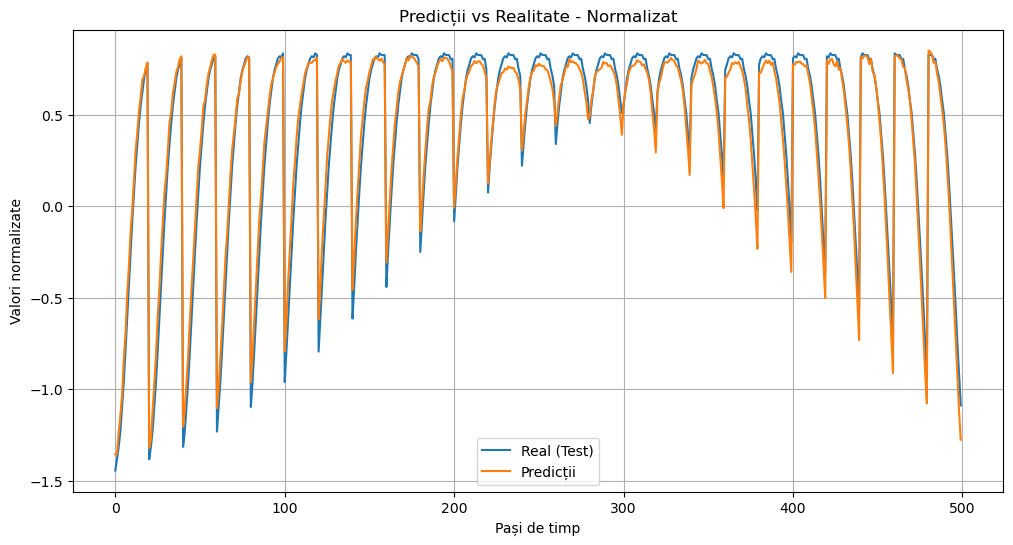

In [15]:
# Predictii pe setul de test (date normalizate)
y_pred_norm = model.predict(X_test, verbose=0).flatten()
y_test_norm = y_test.flatten()

# Calcul metrici pe valori normalizate
mse_norm = mean_squared_error(y_test_norm, y_pred_norm)
mae_norm = mean_absolute_error(y_test_norm, y_pred_norm)
rmse_norm = np.sqrt(mse_norm)
r2_norm = r2_score(y_test_norm, y_pred_norm)
mape_norm = np.mean(np.abs((y_test_norm - y_pred_norm) / y_test_norm)) * 100

print(f"🏆 Performanța modelului (date normalizate):")
print(f"   ├── MSE: {mse_norm:.8f}")
print(f"   ├── MAE: {mae_norm:.8f}")
print(f"   ├── RMSE: {rmse_norm:.8f}")
print(f"   ├── MAPE: {mape_norm:.2f}%")
print(f"   └── R²: {r2_norm:.6f} ({r2_norm*100:.2f}%)")

# Plot pe date normalizate
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm[:500], label='Real (Test)')
plt.plot(y_pred_norm[:500], label='Predicții')
plt.title('Predicții vs Realitate - Normalizat')
plt.xlabel('Pași de timp')
plt.ylabel('Valori normalizate')
plt.legend()
plt.grid(True)
plt.show()
